# MultiClass handwritten digit recognition
### Problem Statement

The problem is how to classifiy handwritten digits from 0-9? 
you will use a neural network to recognize ten handwritten digits, 0-9. This is a multiclass classification task where one of n choices is selected. Automated handwritten digit recognition is widely used today - from recognizing zip codes (postal codes) on mail envelopes to recognizing amounts written on bank checks.

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid
import matplotlib.pyplot as plt
plt.style.use('./deeplearning.mplstyle')

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

from autils import *
from lab_utils_softmax import plt_softmax
np.set_printoptions(precision=2)

In multi-class classification, softmax is used to convert logits into probabilities.
However, we don't apply softmax manually when using loss functions like
nn.CrossEntropyLoss (PyTorch) or SparseCategoricalCrossentropy (TensorFlow),
because these functions apply softmax internally for numerical stability.
Just pass raw logits to the loss function.


The softmax function can be written:
$$a_j = \frac{e^{z_j}}{ \sum_{k=0}^{N-1}{e^{z_k} }} \tag{1}$$

Where $z = \mathbf{w} \cdot \mathbf{x} + b$ and N is the number of feature/categories in the output layer.  

for practice purpose I will implement this, you can use built-in one. 

In [4]:
def my_softmax(z):
    a = (np.exp(z)) / (np.sum(np.exp(z)))
    return a

let's check it how it works?

In [5]:
z = np.array([1., 2., 3., 4., 5.])
a = my_softmax(z)
print(f"my_softmax(z):         {a}")


my_softmax(z):         [0.01 0.03 0.09 0.23 0.64]


In [6]:
#using the built-in softmax
a = tf.nn.softmax(z)
print(f"tensorflow softmax(z): {a}")

tensorflow softmax(z): [0.01 0.03 0.09 0.23 0.64]


### dataset
- The data set contains 5000 training examples of handwritten digits $^1$.  

    - Each training example is a 20-pixel x 20-pixel grayscale image of the digit. 
        - Each pixel is represented by a floating-point number indicating the grayscale intensity at that location. 
        - The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. 
        - Each training examples becomes a single row in our data matrix `X`. 
        - This gives us a 5000 x 400 matrix `X` where every row is a training example of a handwritten digit image.

- The second part of the training set is a 5000 x 1 dimensional vector `y` that contains labels for the training set
    - `y = 0` if the image is of the digit `0`, `y = 4` if the image is of the digit `4` and so on.

$^1$<sub>(http://yann.lecun.com/exdb/mnist/)</sub>


In [9]:
X, y = load_data()

In [10]:
print ('The first element of X is: ', X[0])

The first element of X is:  [ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  8.56e-06  1.94e-06 -7.37e-04
 -8.13e-03 -1.86e-02 -1.87e-02 -1.88e-02 -1.91e-02 -1.64e-02 -3.78e-03
  3.30e-04  1.28e-05  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  1.16e-04  1.20e-04 -1.40e-02 -2.85e-02  8.04e-02
  2.67e-01  2.74e-01  2.79e-01  2.74e-01  2.25e-0

### dimension of X, and y variables

In [11]:
print ('The shape of X is: ' + str(X.shape))
print ('The shape of y is: ' + str(y.shape))

The shape of X is: (5000, 400)
The shape of y is: (5000, 1)


#### Visualize the data 
In the cell below, the code randomly selects 64 rows from X, maps each row back to a 20 pixel by 20 pixel grayscale image and displays the images together along with labels

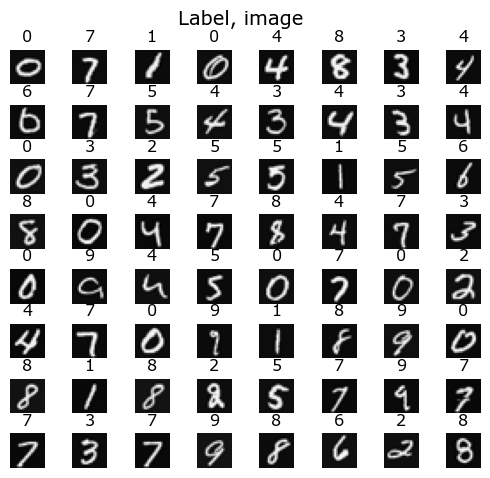

In [12]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# You do not need to modify anything in this cell

m, n = X.shape

fig, axes = plt.subplots(8,8, figsize=(5,5))
fig.tight_layout(pad=0.13,rect=[0, 0.03, 1, 0.91]) #[left, bottom, right, top]

#fig.tight_layout(pad=0.5)
widgvis(fig)
for i,ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)
    
    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = X[random_index].reshape((20,20)).T
    
    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')
    
    # Display the label above the image
    ax.set_title(y[random_index,0])
    ax.set_axis_off()
    fig.suptitle("Label, image", fontsize=14)

## Model architecture
The model for digit classification consists of a neural network with the following architecture:
1. **Input Layer**: The input layer takes in a flattened vector of pixel values from digit images. Since each image is of size 20x20 pixels, the total number of input features is 400.

2. **Hidden Layer 1**: This layer contains 25 units and uses the **ReLU** (Rectified Linear Unit) activation function. ReLU helps introduce non-linearity to the model, allowing it to learn complex patterns.

3. **Hidden Layer 2**: This layer contains 15 units and also uses the **ReLU** activation function.

4. **Output Layer**: The output layer consists of 10 units, corresponding to the 10 possible digit classes (0-9). It uses a **linear activation** function to produce raw logits, which are then passed to the **softmax** function for probability computation.

5. **Softmax Layer**: The softmax function is applied to the output of the final layer to convert the raw logits into a probability distribution. The class with the highest probability is chosen as the predicted digit.

This architecture allows the network to learn from pixel data and classify handwritten digits into one of ten classes.


layer1: The shape of W1 is (400, 25) and the shape of b1 is (25,)

layer2: The shape of W2 is (25, 15) and the shape of b2 is: (15,)

layer3: The shape of W3 is (15, 10) and the shape of b3 is: (10,)

The numerical stability is improved if the softmax is grouped with the loss function rather than the output layer during training. This has implications when building the model and using the model.

In [13]:
tf.random.set_seed(1234) # for consistent results
model = Sequential(
    [               
        Dense(25, activation='relu', name="L1", input_shape=(400,)),  # Define input shape in the first layer
        Dense(15, activation='relu', name="L2"),
        Dense(10, activation='linear', name="L3")

    ], name = "my_model" 
)

C:\Users\sayee\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
model.summary()

Model: "my_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ L1 (Dense)                           │ (None, 25)                  │          10,025 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ L2 (Dense)                           │ (None, 15)                  │             390 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ L3 (Dense)                           │ (None, 10)                  │             160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,575 (41.31 KB)

 Trainable params: 10,575 (41.31 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
[layer1, layer2, layer3] = model.layers

In [16]:
#### Examine Weights shapes
W1,b1 = layer1.get_weights()
W2,b2 = layer2.get_weights()
W3,b3 = layer3.get_weights()
print(f"W1 shape = {W1.shape}, b1 shape = {b1.shape}")
print(f"W2 shape = {W2.shape}, b2 shape = {b2.shape}")
print(f"W3 shape = {W3.shape}, b3 shape = {b3.shape}")

W1 shape = (400, 25), b1 shape = (25,)
W2 shape = (25, 15), b2 shape = (15,)
W3 shape = (15, 10), b3 shape = (10,)


### Compile and fit the model
* defines a loss function, `SparseCategoricalCrossentropy` and indicates the softmax should be included with the  loss calculation by adding `from_logits=True`)
* defines an optimizer. A popular choice is Adaptive Moment (Adam) which was described in lecture.

In [ ]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
)

history = model.fit(
    X,y,
    epochs=40
)

Epoch 1/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 1.9668
Epoch 2/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6793
Epoch 3/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4142
Epoch 4/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3375
Epoch 5/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2952
Epoch 6/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2655
Epoch 7/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2424
Epoch 8/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2240
Epoch 9/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2083
Epoch 10/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1954
Epoch 11/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1836
Epoch 12/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1731
Epoch 13/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1638
Epoch 14/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1545
Epoch 15/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - lo

#### Epochs and batches
In the `fit` statement above, the number of `epochs` was set to 40. This specifies that the entire data set should be applied during training 40 times.  During training, you see output describing the progress of training that looks like this:
```

Epoch 1/40
157/157 [==============================] - 0s 1ms/step - loss: 2.2770
```
The first line, `Epoch 1/40`, describes which epoch the model is currently running. For efficiency, the training data set is broken into 'batches'. The default size of a batch in Tensorflow is 32. There are 5000 examples in our data set or roughly 157 batches. The notation on the 2nd line `157/157 [====` is describing which batch has been executed.

### prediction using the model

In [ ]:
image_of_two = X[1015]
display_digit(image_of_two)

prediction = model.predict(image_of_two.reshape(1,400))  # prediction

print(f" predicting a Two: \n{prediction}")
print(f" Largest Prediction index: {np.argmax(prediction)}")

The largest output is prediction[2], indicating the predicted digit is a '2'. If the problem only requires a selection, that is sufficient. Use NumPy [argmax](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) to select it. If the problem requires a probability, a softmax is required:

In [ ]:
prediction_p = tf.nn.softmax(prediction)

print(f" predicting a Two. Probability vector: \n{prediction_p}")
print(f"Total of predictions: {np.sum(prediction_p):0.3f}")